<a href="https://colab.research.google.com/github/Ndifreke000/Machine-Learning-Algorithms/blob/main/Exploring_Wine_Reviews_through_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Topic Model - an example using Python

In [ ]:
import gensim
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
# import stop words to filter text ahead
stop_words = stopwords.words('english')

# dataset from https://data.world/datafiniti/wine-beer-and-liquor-reviews
df = pd.read_csv("wine_reviews.csv", sep=',', na_values='?', engine='python')

In [ ]:
df.head()

,id,asins,brand,categories,dateAdded,dateUpdated,descriptions,dimension,ean,flavors,...,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,sourceURLs,upc,weight
0,AV13ClKCGV-KLJ3akN68,NaN,Gallo,"Food & Beverage,Beverages,Wine, Beer & Liquor,...",2017-07-24T23:59:11Z,2018-01-10T18:06:28Z,NaN,1.0 in x 1.0 in x 1.0 in,NaN,NaN,...,https://redsky.target.com/groot-domain-api/v1/...,This a fantastic white wine for any occasion!,My Favorite White Wine,NaN,NaN,Bjh,NaN,http://redsky.target.com/v1/plp/search?kwr=y&c...,4.9213E+11,1.0 lbs
1,AV13CsvW-jtxr-f38AQO,NaN,Fresh Craft Co.,"Food & Beverage,Beverages,Wine, Beer & Liquor,...",2017-07-24T23:59:42Z,2018-01-10T05:38:33Z,"[{""dateSeen"":[""2017-12-21T05:43:00.000Z"",""2017...",4.25 in x 4.25 in x 5.25 in,NaN,NaN,...,https://redsky.target.com/groot-domain-api/v1/...,"Tart, not sweet...very refreshing and delicious!",Yum!!,NaN,NaN,Wino,NaN,http://redsky.target.com/v1/plp/search?kwr=y&c...,83120003441,2.45 lbs
2,AV13CVI_glJLPUi8O7Po,NaN,1000 Stories,"Food & Beverage,Beverages,Wine, Beer & Liquor,...",2017-07-24T23:58:05Z,2018-01-10T05:38:31Z,NaN,3.3 in x 3.3 in x 11.79 in,NaN,NaN,...,https://redsky.target.com/groot-domain-api/v1/...,I was given this wine so it was a delightful s...,A New Favorite!,NaN,NaN,Bama Mom,NaN,http://redsky.target.com/v1/plp/search?kwr=y&c...,82896001453,3.09 lbs
3,AV13CVI_glJLPUi8O7Po,NaN,1000 Stories,"Food & Beverage,Beverages,Wine, Beer & Liquor,...",2017-07-24T23:58:05Z,2018-01-10T05:38:31Z,NaN,3.3 in x 3.3 in x 11.79 in,NaN,NaN,...,https://redsky.target.com/groot-domain-api/v1/...,This is a phenomenal wine and my new favorite ...,"Bold, Flavorful, Aromatic, Delicious",NaN,NaN,Av Dub,NaN,http://redsky.target.com/v1/plp/search?kwr=y&c...,82896001453,3.09 lbs
4,AV13CYL4-jtxr-f37_-t,NaN,Wine Cube153,"Food & Beverage,Beverages,Wine, Beer & Liquor,...",2017-07-24T23:58:18Z,2018-01-10T18:06:29Z,"[{""dateSeen"":[""2017-12-21T05:43:00.000Z"",""2017...",1.0 in x 1.0 in x 1.0 in,NaN,NaN,...,https://redsky.target.com/groot-domain-api/v1/...,4 750ml bottles for the price of two With way ...,"Yum! Plus, Environmentally Friendly!",Overland Park,NaN,Chelseamay,NaN,https://redsky.target.com/groot-domain-api/v1/...,85200600465,1.0 lbs


In [ ]:
# check for nan/missing values
df.isna().sum()

id                         0
asins                   2020
brand                     65
categories                 0
dateAdded                  0
dateUpdated                0
descriptions             152
dimension               1052
ean                      724
flavors                 2739
keys                       0
manufacturer            2041
manufacturerNumber       433
name                       0
reviews.date             338
reviews.dateAdded          0
reviews.dateSeen           0
reviews.didPurchase      841
reviews.doRecommend      979
reviews.id              1005
reviews.numHelpful      2264
reviews.rating           445
reviews.sourceURLs         0
reviews.text               1
reviews.title             44
reviews.userCity        2808
reviews.userProvince    2881
reviews.username           1
sizes                   2868
sourceURLs                 0
upc                      147
weight                  1894
dtype: int64

In [ ]:
# we will use the text of the review to find the topics under the reviews, so we can just remove the rows where
# review.text is nan and disregard the rest since we are not going to use the other values
df_reviews = df.copy()
df_reviews.drop(df_reviews[df_reviews['reviews.text'].isna()].index, inplace=True)
df_reviews.isna().sum()['reviews.text']

0

In [ ]:
# utility functions to process the text later
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def bigrams(words, bi_min=24, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
# select the row with the reviews
reviews = df_reviews['reviews.text'].values

# rearrange the reviews into separate words and remove the punctuation, this utility function will do that using gensim
words = sent_to_words(reviews)

# now remove stop words to get a better model
words = remove_stopwords(reviews)

# we get lists with the words of each review, after being processed and the stop words were removed
print(words)

[['fantastic', 'white', 'wine', 'occasion'], ['tart', 'sweet', 'refreshing', 'delicious'], ['given', 'wine', 'delightful', 'surprise', 'find', 'flavorful', 'delicious', 'taste', 'new', 'favorite'], ['phenomenal', 'wine', 'new', 'favorite', 'red'], ['ml', 'bottles', 'price', 'two', 'way', 'less', 'packaging', 'yes', 'please', 'nervous', 'good', 'true', 'like', 'wine', 'fantastic', 'go', 'bit', 'way', 'get', 'live', 'near', 'state', 'line', 'sold', 'state', 'due', 'liquor', 'laws', 'worth'], ['love', 'becks', 'na', 'tastes', 'like', 'regular', 'ale', 'smells', 'like', 'one', 'tastes', 'great', 'na', 'drink', 'friends', 'love', 'great', 'head', 'pour'], ['wine', 'wonderful', 'strong', 'aroma', 'bit', 'bitter', 'bite', 'still', 'goodit', 'worth', 'end'], ['would', 'give', 'one', 'star', 'came', 'clean', 'bottle', 'called', 'sweet', 'red', 'instead', 'get', 'poetic', 'grandiose', 'blend', 'standard', 'practice', 'gets', 'dash', 'grape', 'juice', 'concentrate', 'sweeten', 'also', 'looses', '

In [ ]:
# create bigrams for the words obtained after processing the reviews
bigram_mod = bigrams(words)
bigram = [bigram_mod[review] for review in words]

# create text corpus
id2word = gensim.corpora.Dictionary(bigram)
id2word.filter_extremes()
id2word.compactify()
train_corpus = [id2word.doc2bow(text) for text in bigram]
train_id2word = id2word

In [ ]:
# lets now train our model for say 10 topics
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=10,
                           id2word=id2word,
                            minimum_probability=0.0)
    # uncomment the line below to save your model
    # lda_train.save('lda_train.model')

In [ ]:
topics = lda_train.print_topics(10, num_words=10)
topics

[(0,
  '0.019*"carmex" + 0.016*"love" + 0.016*"good" + 0.014*"like" + 0.013*"wine" + 0.012*"jar" + 0.012*"lips" + 0.011*"would" + 0.011*"flavor" + 0.010*"great"'),
 (1,
  '0.034*"great" + 0.019*"love" + 0.015*"mix" + 0.012*"lips" + 0.012*"make" + 0.011*"use" + 0.011*"good" + 0.011*"like" + 0.010*"really" + 0.008*"best"'),
 (2,
  '0.014*"product" + 0.014*"use" + 0.013*"great" + 0.013*"lips" + 0.012*"carmex" + 0.011*"jar" + 0.011*"one" + 0.010*"price" + 0.010*"taste" + 0.010*"bought"'),
 (3,
  '0.033*"carmex" + 0.028*"love" + 0.022*"lips" + 0.016*"use" + 0.014*"product" + 0.013*"great" + 0.013*"good" + 0.012*"dry" + 0.012*"best" + 0.011*"like"'),
 (4,
  '0.023*"one" + 0.014*"product" + 0.013*"good" + 0.012*"best" + 0.010*"great" + 0.009*"never" + 0.009*"wine" + 0.008*"like" + 0.008*"use" + 0.008*"years"'),
 (5,
  '0.023*"product" + 0.016*"great" + 0.015*"carmex" + 0.014*"lips" + 0.014*"love" + 0.013*"good" + 0.013*"time" + 0.012*"used" + 0.012*"mix" + 0.011*"like"'),
 (6,
  '0.027*"great

Text(0.5, 1.0, 'Topics distribution - Wine Reviews')

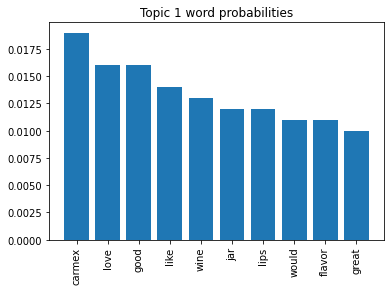

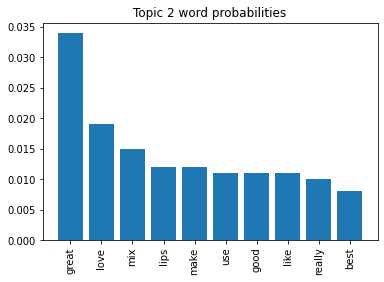

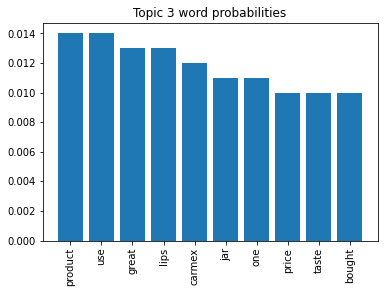

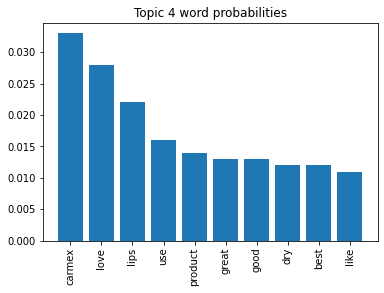

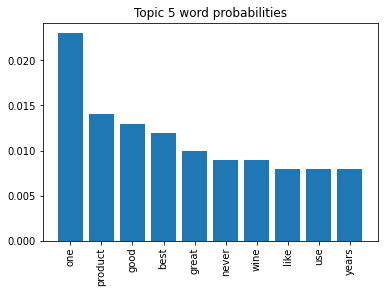

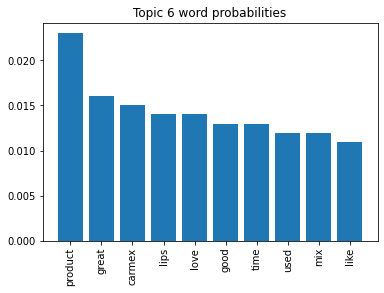

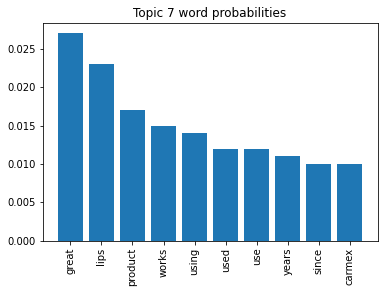

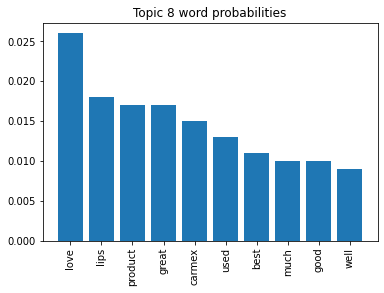

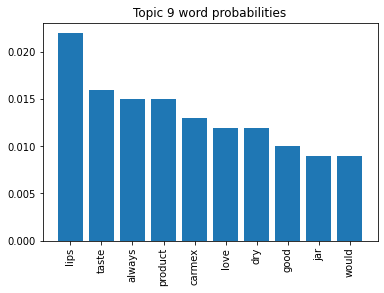

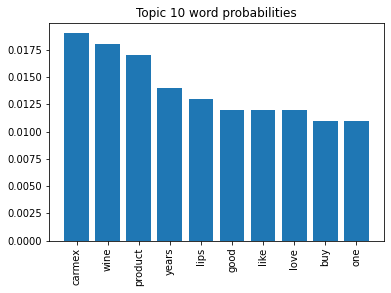

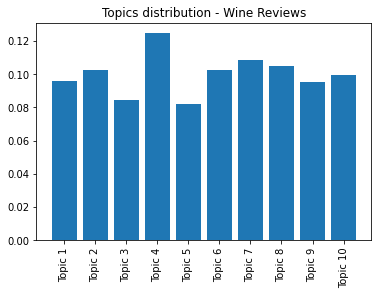

In [ ]:
# lets now plot our resuts
# to do that, we will use a procedure to process the list outputed by our model

num_topics = 10
topic_sums, topic_labels = [], []

for i in range(0, num_topics):
    sum_i = 0
    weights, word_labels = [], []
    topic_i = topics[i][1]  # get topic text
    topic_i_weight_words = topic_i.split(" + ")  # split topic
    for weight_word in topic_i_weight_words:
        sum_i += float(weight_word[0:5])
        weights.append(float(weight_word[0:5]))
        word_labels.append(weight_word[7:len(weight_word)-1])

    # plot values
    plt.figure(i+1)
    plt.bar(word_labels, weights)
    plt.xticks(rotation=90)
    plt.title("Topic %d word probabilities" % (i + 1))
    topic_sums.append(sum_i)
    topic_labels.append("Topic %d" % (i+1))

# now plot the distribution of the topics found, in relation to their weight in the model
total = sum(topic_sums)
topic_weights = [topic_sums[i]/total for i in range(len(topic_sums))]
plt.figure(num_topics + 1)
plt.bar(topic_labels, topic_weights)
plt.xticks(rotation=90)
plt.title("Topics distribution - Wine Reviews")